In [147]:
#%%
import os
import sys
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm
from linearmodels.iv import IV2SLS

%matplotlib inline
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#%%

## Read data

In [148]:
working = '/home/alal/Desktop/code/eq-svy-eda'
%cd $working
%time hh_all = pd.read_csv(working+'/data/interim/hh_with_geo.csv')

/home/alal/Desktop/code/eq-svy-eda


<string>:2: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 6.26 s, sys: 417 ms, total: 6.68 s
Wall time: 6.68 s


In [149]:
hh_all.columns

Index(['VDC-Municipality-Code', 'VDC-Municipality-Name', 'District',
       'District_Name', 'FullSample', 'household_id', 'district_id',
       'vdcmun_id', 'ward_id', 'gender_household_head', 'age_household_head',
       'caste_household', 'education_level_household_head',
       'income_level_household', 'size_household',
       'is_bank_account_present_in_household', 'id',
       'shelter_condition_household_post_eq', 'residence_household_pre_eq',
       'residence_household_post_eq', 'household_eq_id_type',
       'has_death_occurred_last_12_months', 'count_death_last_12_months',
       'has_injury_loss_occurred_last_12_months',
       'count_injury_loss_last_12_months',
       'has_education_drop_occurred_last_12_months',
       'count_education_drop_last_12_months',
       'has_pregnancy_treatment_drop_occurred_last_12_months',
       'count_pregnancy_treatment_drop_last_12_months',
       'has_vaccination_drop_occurred_last_12_months',
       'count_vaccination_drop_last_12_mon

In [150]:
hh_all.has_death_occurred_last_12_months.value_counts()

0.0    1011162
1.0      25178
Name: has_death_occurred_last_12_months, dtype: int64

In [151]:
hh_all['post_eq_effects']=hh_all[['has_death_occurred_last_12_months',
                                  'has_injury_loss_occurred_last_12_months',
                                  'has_education_drop_occurred_last_12_months',
                                  'has_pregnancy_treatment_drop_occurred_last_12_months',
                                  'has_vaccination_drop_occurred_last_12_months',
                                  'has_occupation_change_occurred_last_12_months']].max(axis=1)

In [152]:
hh_all['post_eq_effects'].value_counts()

0.0    987244
1.0     49096
Name: post_eq_effects, dtype: int64

In [153]:
hh_all['aid']=hh_all[['is_recipient_rahat_15k',
                      'is_recipient_rahat_10k', 'is_recipient_rahat_200k']].max(axis=1)

In [154]:
hh_all['aid'].value_counts()

1    692295
0    344273
Name: aid, dtype: int64

construct aggregated caste groups

In [155]:
bcn_mapping = {
'Brahman-Hill': 'BCN',
'Brahman-Tarai': 'BCN',
'Chhetree': 'BCN',
'Newar': 'BCN',
'Thakuri': 'BCN',
'Majhi': 'non-BCN',
'Rai': 'non-BCN',
'Kami': 'non-BCN',
'Magar': 'non-BCN',
'Damai/Dholi': 'non-BCN',
'Limbu': 'non-BCN',
'Sarki': 'non-BCN',
'Yakkha': 'non-BCN',
'Tamang': 'non-BCN',
'Gharti/Bhujel': 'non-BCN',
'Sanyasi/Dashnami': 'non-BCN',
'Gurung': 'non-BCN',
'0thers': 'non-BCN',
'Khawas': 'non-BCN',
'Teli': 'non-BCN',
'Kumal': 'non-BCN',
'Byasi/Sauka': 'non-BCN',
'Sherpa': 'non-BCN',
'Mewahang Bala': 'non-BCN',
'Kulung': 'non-BCN',
'Jhangad/Dhagar': 'non-BCN',
'Lohar': 'non-BCN',
'Bhote': 'non-BCN',
'Sunuwar': 'non-BCN',
'Ghale': 'non-BCN',
'Thulung': 'non-BCN',
'Khaling': 'non-BCN',
'Chamling': 'non-BCN',
'Thami': 'non-BCN',
'Gaderi/Bhedhar': 'non-BCN',
'Sonar': 'non-BCN',
'Hayu': 'non-BCN',
'Gaine': 'non-BCN',
'Musalman': 'non-BCN',
'Pahari': 'non-BCN',
'Jirel': 'non-BCN',
'Baraee': 'non-BCN',
'Kurmi': 'non-BCN',
'Nachhiring': 'non-BCN',
'Rajbansi': 'non-BCN',
'Yadav': 'non-BCN',
'Brahmu/Baramo': 'non-BCN',
'Raute': 'non-BCN',
'Tharu': 'non-BCN',
'Dhanuk': 'non-BCN',
'Danuwar': 'non-BCN',
'Bin': 'non-BCN',
'Chepang/Praja': 'non-BCN',
'Hajam/Thakur': 'non-BCN',
'Darai': 'non-BCN',
'Kumhar': 'non-BCN',
'Kanu': 'non-BCN',
'Rajput': 'non-BCN',
'Chhantyal/Chhantel': 'non-BCN',
'Thakali': 'non-BCN',
'Kayastha': 'non-BCN',
'Kalwar': 'non-BCN',
'Tatma/Tatwa': 'non-BCN',
'Badhaee': 'non-BCN',
'Bote': 'non-BCN',
'Sudhi': 'non-BCN',
'Chamar/Harijan/Ram': 'non-BCN',
'Musahar': 'non-BCN',
'Dusadh/Pasawan/Pasi': 'non-BCN',
'Kamar': 'non-BCN',
'Satar/Santhal': 'non-BCN',
'Dura': 'non-BCN',
'Gangai': 'non-BCN',
'Marwadi': 'non-BCN',
'Dom': 'non-BCN',
'Kisan': 'non-BCN',
'Loharung': 'non-BCN',
'Mallaha': 'non-BCN',
'Kewat': 'non-BCN',
'Koiri/Kushwaha': 'non-BCN',
'Kahar': 'non-BCN',
'Kusunda': 'non-BCN',
'Lepcha': 'non-BCN',
'Mali': 'non-BCN',
'Nuniya': 'non-BCN',
'Dhobi': 'non-BCN',
'Punjabi/Shikh': 'non-BCN',
'Hyolmo': 'non-BCN',
'Khatwe': 'non-BCN',
'Haluwai': 'non-BCN',
'Amat': 'non-BCN',
'Kori': 'non-BCN',
'Badi': 'non-BCN',
'Bantar/Sardar': 'non-BCN',
'Kalar': 'non-BCN',
'Dhimal': 'non-BCN',
'Meche': 'non-BCN',
'Lhopa': 'non-BCN',
'Koche': 'non-BCN',
'Kathbaniyan': 'non-BCN',
'Dev': 'non-BCN',
'Bahing': 'non-BCN',
'Bangali': 'non-BCN',
'Pattharkatta/Kushwadiya': 'non-BCN',
'Samgpang': 'non-BCN',
'Natuwa':'non-BCN'
}

In [156]:
hh_all['caste_general']=hh_all.caste_household.map(bcn_mapping)
hh_all['caste_general'].value_counts()

non-BCN    559398
BCN        476942
Name: caste_general, dtype: int64

In [157]:
# village houeshold counts
hh_all['village_counts']=hh_all.groupby('vdcmun_id').household_id.transform('count')
# tag BCN households
hh_all['bcn']=hh_all.caste_general=='BCN'
# village BCN aggregates
hh_all['village_bcn_counts']=hh_all.groupby('vdcmun_id').bcn.transform('sum')
# village BCN share
hh_all['bcn_share']=hh_all.village_bcn_counts / hh_all.village_counts

In [158]:
hh_all.head()

VDC-Municipality-Code VDC-Municipality-Name  District District_Name  \
0                    1.0                 Ahale       7.0      dhankuta   
1                    1.0                 Ahale       7.0      dhankuta   
2                    1.0                 Ahale       7.0      dhankuta   
3                    1.0                 Ahale       7.0      dhankuta   
4                    1.0                 Ahale       7.0      dhankuta   

   FullSample  household_id  district_id  vdcmun_id  ward_id  \
0         0.0  701020001101            7        701    70102   
1         0.0  701020002101            7        701    70102   
2         0.0  701020003101            7        701    70102   
3         0.0  701030001101            7        701    70103   
4         0.0  701030002101            7        701    70103   

  gender_household_head    ...     has_asset_four_wheeler_family_use_post_eq  \
0                  Male    ...                                             0   
1                  Male    ...                                             0   
2                  Male    ...                                             0   
3                  Male    ...                                             0   
4                  Male    ...                                             0   

  has_asset_four_wheeler_commercial_post_eq has_asset_none_post_eq  \
0                                         0                      0   
1                                         0                      0   
2                                         0                      0   
3                                         0                      0   
4                                         0                      0   

  post_eq_effects  aid  caste_general  village_counts    bcn  \
0             0.0    0        non-BCN              36  False   
1             0.0    0        non-BCN              36  False   
2             0.0    0        non-BCN              36  False   
3             0.0    0        non-BCN              36  False   
4             0.0    0        non-BCN              36  False   

  village_bcn_counts bcn_share  
0                3.0  0.083333  
1                3.0  0.083333  
2                3.0  0.083333  
3                3.0  0.083333  
4                3.0  0.083333  

[5 rows x 80 columns]

## diagnostic plots

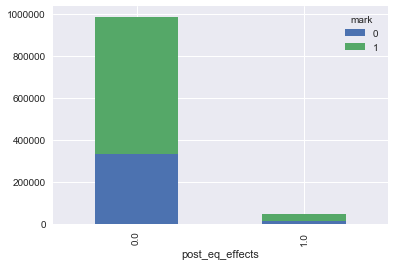

In [159]:
ct = pd.crosstab(hh_all.post_eq_effects, hh_all.aid)

ct.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()


count    1428.000000
mean        0.391688
std         0.256283
min         0.000000
25%         0.172990
50%         0.406775
75%         0.582181
max         1.000000
Name: bcn_share, dtype: float64

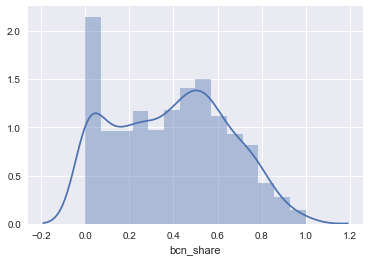

In [160]:
hh_all.groupby('vdcmun_id').bcn_share.agg('first').describe().T
sns.distplot(hh_all.groupby('vdcmun_id').bcn_share.agg('first'))

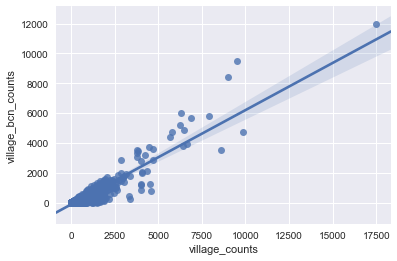

In [161]:
sns.regplot(x=hh_all.groupby('vdcmun_id').village_counts.agg('first'), 
            y=hh_all.groupby('vdcmun_id').village_bcn_counts.agg('first'))

## OLS Regressions

In [162]:
ols_endog = smf.ols('post_eq_effects ~ aid + size_household',data=hh_all).fit(cov_type='HC0')
print(ols_endog.summary())

                            OLS Regression Results                            
Dep. Variable:        post_eq_effects   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1339.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:43:56   Log-Likelihood:             1.3611e+05
No. Observations:             1036340   AIC:                        -2.722e+05
Df Residuals:                 1036337   BIC:                        -2.722e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0251      0.001     48.

In [163]:
first_stage = smf.ols("aid ~ bcn_share + size_household", data=hh_all).fit(cov_type='HC0')
print(first_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                    aid   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4741.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:43:56   Log-Likelihood:            -6.8564e+05
No. Observations:             1036566   AIC:                         1.371e+06
Df Residuals:                 1036563   BIC:                         1.371e+06
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5643      0.001    403.

In [164]:
reduced_form = smf.ols('post_eq_effects ~ bcn_share + size_household',data=hh_all).fit(cov_type='HC0')
print(reduced_form.summary())

                            OLS Regression Results                            
Dep. Variable:        post_eq_effects   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     407.5
Date:                Sat, 24 Feb 2018   Prob (F-statistic):          1.27e-177
Time:                        22:43:57   Log-Likelihood:             1.3533e+05
No. Observations:             1036340   AIC:                        -2.707e+05
Df Residuals:                 1036337   BIC:                        -2.706e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0455      0.001     69.

## IV Estimation

In [165]:
iv = IV2SLS.from_formula('post_eq_effects ~ 1 + size_household + [aid ~ bcn_share]',
                         data=hh_all).fit(cov_type='robust')
print(iv.summary)

/home/alal/anaconda3/envs/gds/lib/python3.5/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          IV-2SLS Estimation Summary                          
Dep. Variable:        post_eq_effects   R-squared:                     -0.0542
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0542
No. Observations:             1036340   F-statistic:                    774.33
Date:                Sat, Feb 24 2018   P-value (F-stat)                0.0000
Time:                        22:43:59   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          0.0952     0.0033     29.047     0.0000      0.0888      0.1016
size_household     0.0022  9.404e-05

OLS $\partial N / \partial r > 0$ (i.e. More aid, more bad outcomes) - strong selection bias

In [166]:
ols_endog.params[1]

0.019327205312799443

IV $\partial N / \partial r < 0$ (i.e. more aid, fewer bad outcomes)

In [167]:
iv.params[2]

-0.08800432378046708